In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Time series tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option("display.max_columns", None)

In [2]:
# Load cleaned data
df = pd.read_csv("../data/processed_data/train_clean.csv")

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by time (VERY IMPORTANT)
df = df.sort_values("Date")

df.head()

/var/folders/4y/jgs7sbvs2n92vmw0q53pv0580000gn/T/ipykernel_23271/3693764214.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed_data/train_clean.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,Day,CompetitionDuration,Promo2Duration,CustomerBin,CustomerGroup,CompetitionGroup
844391,1097,1,2013-01-01,5961,1405,1,0,a,1,b,b,720.0,3.0,2002.0,0,0.0,0.0,NaN,2013,1,1,1,11.0,0.0,"(1116.0, 7388.0]",1000+,501–1000 m
844375,85,1,2013-01-01,4220,619,1,0,a,1,b,a,1870.0,10.0,2011.0,0,0.0,0.0,NaN,2013,1,1,1,2.0,0.0,"(609.0, 688.0]",501–1000,1001–2000 m
844376,259,1,2013-01-01,6851,1444,1,0,a,1,b,b,210.0,0.0,0.0,0,0.0,0.0,NaN,2013,1,1,1,0.0,0.0,"(1116.0, 7388.0]",1000+,0–500 m
844377,262,1,2013-01-01,17267,2875,1,0,a,1,b,a,1180.0,5.0,2013.0,0,0.0,0.0,NaN,2013,1,1,1,0.0,0.0,"(1116.0, 7388.0]",1000+,1001–2000 m
844378,274,1,2013-01-01,3102,729,1,0,a,1,b,b,3640.0,0.0,0.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,0.0,"(688.0, 780.0]",501–1000,2001–5000 m


In [3]:
# Aggregate total daily sales across all stores
daily_sales = df.groupby("Date")["Sales"].sum()

daily_sales.head()

Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Name: Sales, dtype: int64

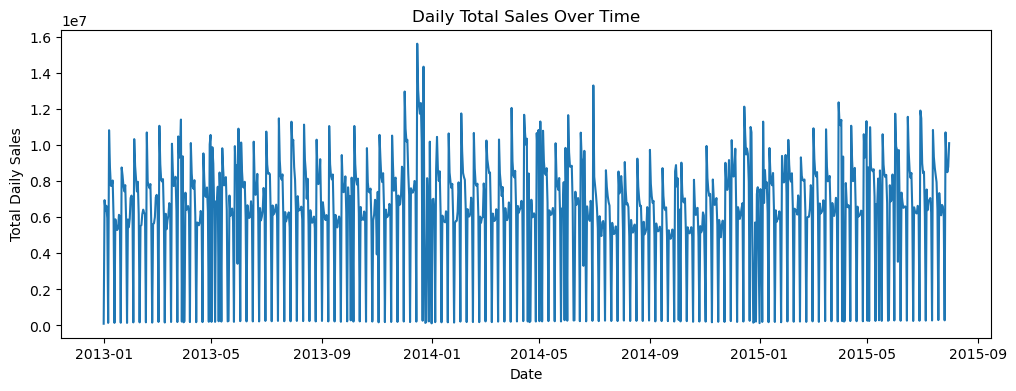

In [4]:
# ploting raw time series

plt.figure(figsize=(12,4))
plt.plot(daily_sales)
plt.xlabel("Date")
plt.ylabel("Total Daily Sales")
plt.title("Daily Total Sales Over Time")
plt.show()

Why this graph was done

This plot shows how sales change over time in their original form. It is the first and most important visualization in any time series analysis.

Why it is important:

	•	Helps identify overall trend (increasing, decreasing, stable)
	•	Reveals flexibility, sudden spikes, or drops
	•	Detects structural breaks (unexpected changes)

Without this plot, we would be analyzing numbers without understanding their time behavior.

How it helps our project

This plot confirms that sales are time-dependent and not random. It justifies treating the problem as a time series forecasting problem, which supports the later use of sequence-based models like LSTM.

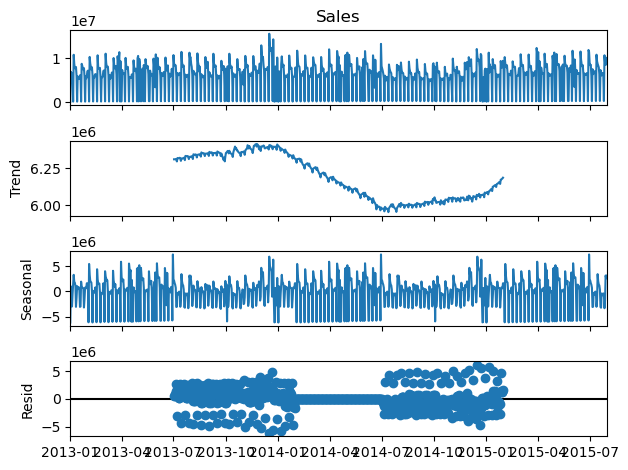

In [5]:
# Checking Trend, Seasonality, Noise

# Decompose time series
decomposition = seasonal_decompose(
    daily_sales,
    model="additive",
    period=365
)

decomposition.plot()
plt.show()

Why this graph was done

Seasonal decomposition separates the time series into:
	•	Trend (long-term movement)
	•	Seasonality (repeating patterns)
	•	Residual (random noise)

Why it is important

It helps us understand what drives sales changes:

	•	Is growth due to long-term trend?
	•	Are there repeating seasonal patterns?
	•	How much noise exists in the data?

 How it helps our project

The decomposition confirms that sales have strong seasonal and trend components, which means:

	•	Time-based models are suitable
	•	LSTM can learn complex temporal patterns
	•	Simple static models may miss important signals

In [6]:
# ADF test
adf_result = adfuller(daily_sales)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -4.761614524595612
p-value: 6.436731330559378e-05


<Figure size 1000x400 with 0 Axes>

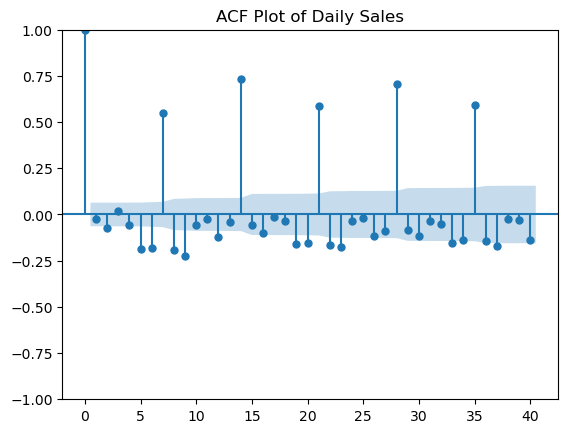

<Figure size 1000x400 with 0 Axes>

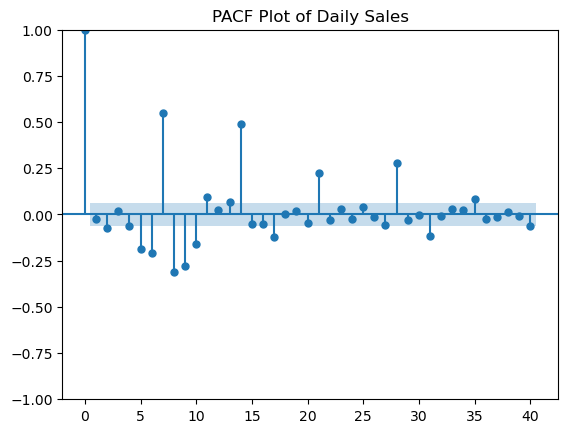

In [8]:
# Autocorrelation Analysis (Stationary Series)

plt.figure(figsize=(10,4))
plot_acf(daily_sales, lags=40)
plt.title("ACF Plot of Daily Sales")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(daily_sales, lags=40)
plt.title("PACF Plot of Daily Sales")
plt.show()

 Why these graphs were done

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots were used together to analyze how current sales values depend on past sales values over different time lags. While ACF shows overall correlation with past values, PACF highlights the direct influence of specific lags by removing indirect effects.

 Why this analysis is important

Autocorrelation analysis helps:

	•	Determine how long past sales influence future sales
	•	Identify temporal dependency and memory in the data
	•	Understand whether the time series contains meaningful lag relationships

Using both ACF and PACF together provides a complete picture of short-term and long-term dependencies in the time series.


 How this helps our project

The presence of significant autocorrelation across multiple lags confirms that past sales strongly influence future sales. This validates the use of sequence-based models such as LSTM, which are designed to learn from historical patterns. Additionally, ACF and PACF help guide the selection of an appropriate time window (number of past days) for LSTM input, avoiding arbitrary sequence length choices.


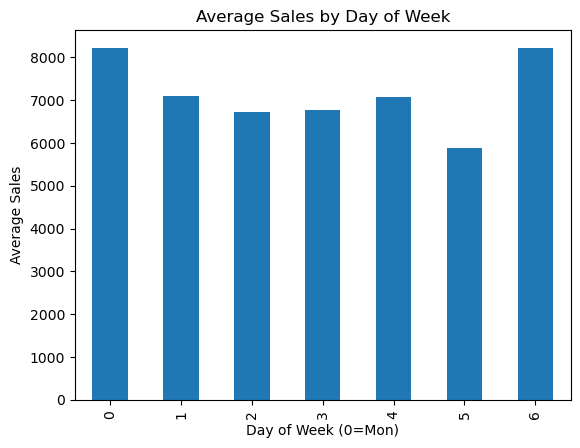

In [9]:
# Weekly seasonality
weekly_sales = df.groupby(df["Date"].dt.dayofweek)["Sales"].mean()

weekly_sales.plot(kind="bar", title="Average Sales by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Sales")
plt.show()

 Why this graph was done

This plot checks whether sales vary by day of the week, which is very common in retail data.

 Why it is important

Customer behavior often differs between:

	•	Weekdays
	•	Weekends

Ignoring this can reduce model accuracy.

 How it helps our project

This confirms weekly seasonality, justifying:

	•	Time-based feature usage
	•	Sequence learning models
	•	Better forecasting accuracy